<a href="https://colab.research.google.com/github/hrithikwel8/Rossmann_Sales_Prediction/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import random

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Capstone Project/Retail Sales Prediction/data/'
store_data_df = pd.read_csv(path + 'Rossmann Stores Data.csv')
store_df = pd.read_csv(path + 'store.csv')

#1. EDA

We have 2 data files. Let's explore what each data file contains.

In [ ]:
store_data_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


"store.csv" file contains information about store data. It contains details for 1115 stores, each store have a unique id number which is given in the 'Store' column.
Type of store and its Assortment Level are also given in the dataset.

All businesses have competitions even drug stores have competition.
To overcome this competitive environment a store can run promotions to attract more customers and that leads to more sales.

Details of competition and promotional also present in dataset.

In [ ]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
store_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


Let's look at missing values in the dataset.

In [ ]:
missing_values= store_df.isnull()

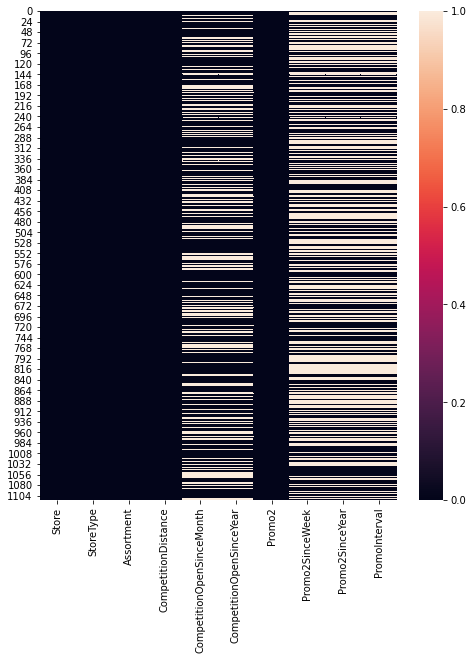

In [ ]:
#Heatmap of missing values in the store_df 
plt.figure(figsize=(8,9))
sns.heatmap(missing_values)

Most of missing values are from competition open time and promotion start time.
If competition distance is large we don't need to worry about the competition as it will have less effect on store sales. We can fill all competition start time missing details as 0 for place holder which indicates no competition for the current store. 

If store is not running promotion then we can set promotion start time as 0 as well.

In [ ]:
store_df['CompetitionOpenSinceMonth'].fillna(0,inplace=True)
store_df['CompetitionOpenSinceYear'].fillna(0,inplace=True)
store_df['CompetitionDistance'].fillna(0,inplace=True)

In [ ]:
# this features shows NaN values for all the stores which doesnt run promos and hence we substitute the value of Nan to 0
store_df['Promo2SinceWeek'].fillna(0,inplace=True)
store_df['Promo2SinceYear'].fillna(0,inplace=True)

In [ ]:
store_df['PromoInterval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

'Promo2' is a continuous promotion that runs for a specific month.
We can see that the promotion interval is given in 3 unique values.
Each promotion runs for a month then it starts again after 2 months.
Since we have unique values to deal with we can assign a binary variable for each value. we will add 1 for present and 0 for absent. Thus we can have 3 new features containing binary values for promotion interval time. 

In [ ]:
store_df['Assortment'].value_counts()

a    593
c    513
b      9
Name: Assortment, dtype: int64

In [ ]:
store_df['StoreType'].value_counts()

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

'Assortment' column contains 3 unique values, we can assign numerical values to feed the data in a machine learning model.

'StoreType' column also contains 4 unique values that can be assigned numerical values.

In [ ]:
# Function definition for Converting Qualitative Values to Quantitative
def Promo_interval1(row):
  if (row['PromoInterval'] == 'Jan,Apr,Jul,Oct'):
    val = 1
  else:
    val = 0
  return val
def Promo_interval2(row):
  if (row['PromoInterval'] == 'Feb,May,Aug,Nov'):
    val = 1
  else:
    val = 0
  return val
def Promo_interval3(row):
  if (row['PromoInterval'] == 'Mar,Jun,Sept,Dec'):
    val = 1
  else:
    val = 0
  return val
def store_type(row):
  if (row['StoreType'] == 'a'):
    val = 1
  elif (row['StoreType'] == 'b'):
    val = 2
  elif (row['StoreType'] == 'c'):
    val = 3
  else:
    val = 4
  return val
def assortment_level(row):
  if (row['Assortment'] == 'a'):
    val = 1
  elif (row['Assortment'] == 'b'):
    val = 2
  else:
    val = 3
  return val

In [ ]:
# apply function to create new features in dataset
store_df['PromoInterval1'] = store_df.apply(Promo_interval1,axis=1)
store_df['PromoInterval2'] = store_df.apply(Promo_interval2,axis=1)
store_df['PromoInterval3'] = store_df.apply(Promo_interval3,axis=1)
store_df['Store_Type'] = store_df.apply(store_type,axis=1)
store_df['Assortment_Level'] = store_df.apply(assortment_level,axis=1)

In [ ]:
# drop old columns as we have extracted useful data from them
store_df.drop(labels='PromoInterval',axis=1,inplace=True)
store_df.drop(labels='StoreType',axis=1,inplace=True)
store_df.drop(labels='Assortment',axis=1,inplace=True)

In [ ]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   CompetitionDistance        1115 non-null   float64
 2   CompetitionOpenSinceMonth  1115 non-null   float64
 3   CompetitionOpenSinceYear   1115 non-null   float64
 4   Promo2                     1115 non-null   int64  
 5   Promo2SinceWeek            1115 non-null   float64
 6   Promo2SinceYear            1115 non-null   float64
 7   PromoInterval1             1115 non-null   int64  
 8   PromoInterval2             1115 non-null   int64  
 9   PromoInterval3             1115 non-null   int64  
 10  Store_Type                 1115 non-null   int64  
 11  Assortment_Level           1115 non-null   int64  
dtypes: float64(5), int64(7)
memory usage: 104.7 KB


In [ ]:
store_df.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval1,PromoInterval2,PromoInterval3,Store_Type,Assortment_Level
0,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,3,1
1,2,570.0,11.0,2007.0,1,13.0,2010.0,1,0,0,1,1
2,3,14130.0,12.0,2006.0,1,14.0,2011.0,1,0,0,1,1
3,4,620.0,9.0,2009.0,0,0.0,0.0,0,0,0,3,3
4,5,29910.0,4.0,2015.0,0,0.0,0.0,0,0,0,1,1


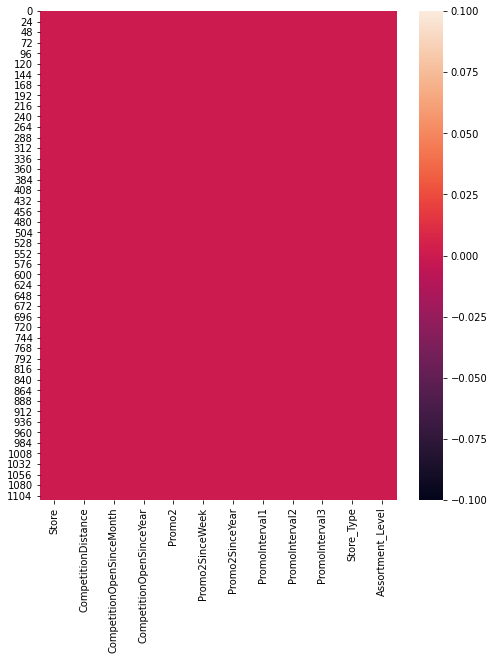

In [ ]:
# The heatmap after filling all the NaN values
final_na_df= store_df.isnull()
plt.figure(figsize=(8,9))
sns.heatmap(final_na_df)

We have cleaned the data set. Let's check how much correlation each variable have with each other.

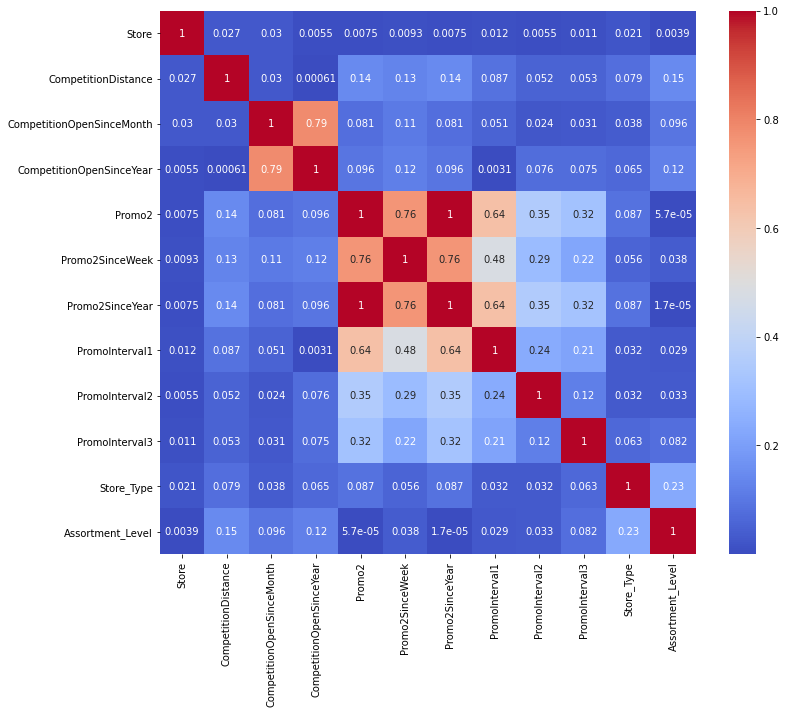

In [ ]:
plt.figure(figsize=(12,10))
correlation = store_df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

Now let's explore "Rossmann Stores Data.csv" data file.

In [ ]:
store_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


This dataset contains information about a particular day for all the stores. Date column contains information about the date on which data is collected.

This dataset contains our dependent variable 'Sales' which we need to predict.
We have information about the number of customers that visited the store on the date.

Open column gives information if the store was open or closed on the date.
We also have information about state holidays and school holidays.

Promo column contains information about a promotion offer running on a particular day. This is a special promotional offer that runs for only a given day.

In [ ]:
store_data_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


Let's find out how many stores are open and how many are closed from the dates given in the dataset.

This information gives us an idea about what is the probability of the store being open on a particular date.

Text(0.5, 0, '')

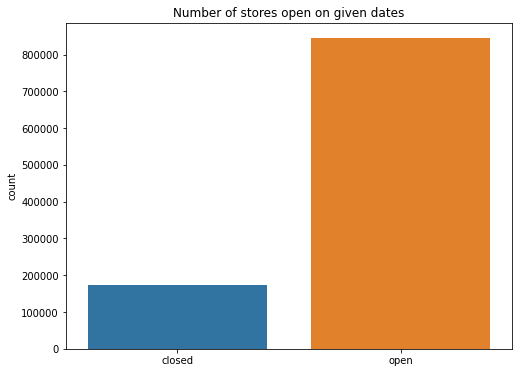

In [ ]:
# number of stores open on a given day
plt.figure(figsize=(8,6))
count = sns.countplot(x=store_data_df['Open'])
count.set_title('Number of stores open on given dates')
count.set_xticklabels(['closed', 'open'])
count.set_xlabel('')

Promotional offers attract more customers that lead to increase in sales. Let's find out how many stores run a promotional offer on given dates.

Text(0.5, 0, '')

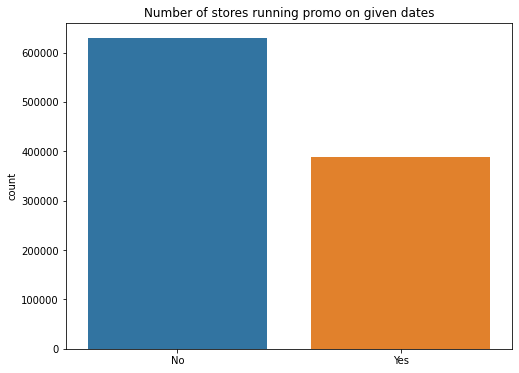

In [ ]:
# number of promo 
plt.figure(figsize=(8,6))
count = sns.countplot(x=store_data_df['Promo'])
count.set_title('Number of stores running promo on given dates')
count.set_xticklabels(['No', 'Yes'])
count.set_xlabel('')

On school holidays schools remain closed. Does this affect the Sales of stores? Let's find out the number of days schools are closed.

Text(0.5, 0, '')

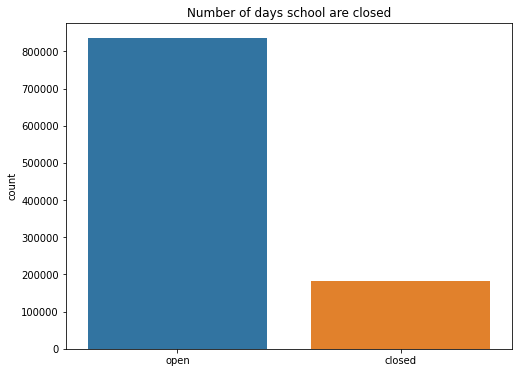

In [ ]:
# number of school holiday
plt.figure(figsize=(8,6))
count = sns.countplot(x=store_data_df['SchoolHoliday'])
count.set_title('Number of days school are closed')
count.set_xticklabels(['open', 'closed'])
count.set_xlabel('')

In [ ]:
store_data_df['StateHoliday'].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

The state holiday data is mixed data of 'string' and 'int' type of variable.

The data contains information about the type of holiday. There are 3 types of holidays, we can make 3 new features for each holiday and convert them to a binary value.

In [ ]:
# convert StateHoliday to binary value features
# 1 indicates holiday and 0 indicates no holiday
store_data_df['public_holiday'] = store_data_df['StateHoliday'].apply(lambda x: 1 if x=='a' else 0)
store_data_df['easter_holiday'] = store_data_df['StateHoliday'].apply(lambda x: 1 if x=='b' else 0)
store_data_df['christmas'] = store_data_df['StateHoliday'].apply(lambda x: 1 if x=='c' else 0)
store_data_df.drop(columns=['StateHoliday'], inplace=True)

In [ ]:
store_data_df['public_holiday'].value_counts()

0    996949
1     20260
Name: public_holiday, dtype: int64

In [ ]:
store_data_df['easter_holiday'].value_counts()

0    1010519
1       6690
Name: easter_holiday, dtype: int64

In [ ]:
store_data_df['christmas'].value_counts()

0    1013109
1       4100
Name: christmas, dtype: int64

After getting the numbers of holidays, we can see the ratio of the holiday celebrated by stores. Let's see how many holidays are celebrated by the stores on given dates.

Text(0.5, 1.0, 'Number of Holidays celebrated by stores')

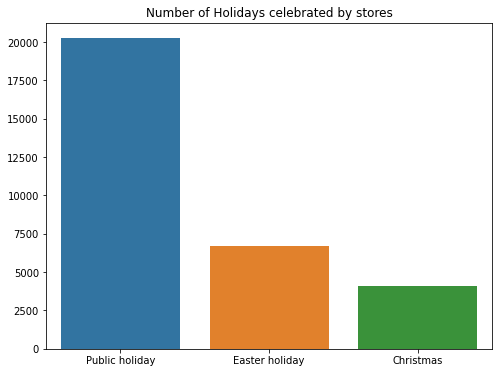

In [ ]:
# plot number of holidays present in dataset
plt.figure(figsize=(8,6))
sns.barplot(x=['Public holiday','Easter holiday','Christmas'],
            y=[store_data_df['public_holiday'].value_counts()[1],store_data_df['easter_holiday'].value_counts()[1],store_data_df['christmas'].value_counts()[1]])
plt.title('Number of Holidays celebrated by stores')

We have given information about stores being closed for refurbishment. We can assume that data for the stores that are closed for refurbishment is not present.
Let's see how many days contain information about how many store data. 

Text(0.5, 1.0, 'Number of Store data given by date')

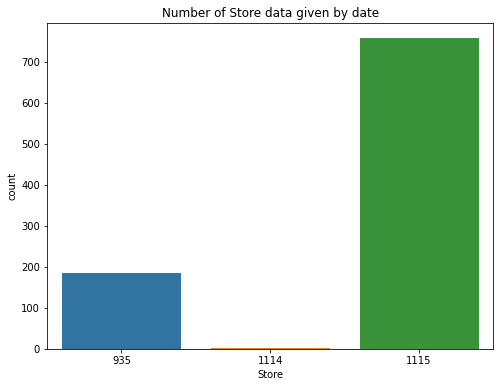

In [ ]:
# count number of stores data given by date
plt.figure(figsize=(8,6))
sns.countplot(store_data_df.groupby(['Date'])['Store'].count())
plt.title('Number of Store data given by date')

In [ ]:
store_data_df.groupby(['Date'])['Store'].count().value_counts()

1115    757
935     184
1114      1
Name: Store, dtype: int64

Data for 170 stores is not given for 184 days. 

We can assume that these stores are closed for refurbishment.

The dates are given as string we can convert them to 3 new columns 'Day, Month and Year'.

In [ ]:
# changing date from string to integer values
def get_year(date):
  year = date[:4]
  return int(year)
def get_month(date):
  month = date[5:7]
  return int(month)
def get_day(date):
  day = date[8:]
  return int(day)

In [ ]:
# create new features
store_data_df['Year'] = store_data_df['Date'].apply(lambda x: get_year(x))
store_data_df['Month'] = store_data_df['Date'].apply(lambda x: get_month(x))
store_data_df['Day'] = store_data_df['Date'].apply(lambda x: get_day(x))
# remove old Date column
store_data_df.drop(columns=['Date'], inplace=True)

In [ ]:
store_data_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day
0,1,5,5263,555,1,1,1,0,0,0,2015,7,31
1,2,5,6064,625,1,1,1,0,0,0,2015,7,31
2,3,5,8314,821,1,1,1,0,0,0,2015,7,31
3,4,5,13995,1498,1,1,1,0,0,0,2015,7,31
4,5,5,4822,559,1,1,1,0,0,0,2015,7,31


In [ ]:
# checking senity of data
store_open_df = store_data_df.groupby(['Open']).sum()
store_open_df

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day
Open,,,,,,,,,,,,
0,96511898,1094583,0,0,11184,18264,19566,6545,4029,348024755,1011285,2601495
1,471527846,2972565,5873180623,644041755,376896,163457,694,145,71,1700463577,4936094,13371524


We have information about holidays. But how to make it useful in Sales predictions?

We know that we don't make any sales when a store is closed.

So, if we can figure out how many stores are closed on holidays, we can use this data to calculate the probability of how many stores will be open for a given holiday.

From this probability, we can predict if the store is going to be open on a particular day or not.

In [ ]:
# calculate number of stores open on holidays
store_holiday_df = store_open_df[['SchoolHoliday', 'public_holiday', 'easter_holiday', 'christmas']].reset_index()
store_holiday_df['Open'] = store_holiday_df['Open'].apply(lambda x: 'Open' if x==1 else 'Closed')
store_holiday_df

,Open,SchoolHoliday,public_holiday,easter_holiday,christmas
0,Closed,18264,19566,6545,4029
1,Open,163457,694,145,71


In [ ]:
# melt the data frame to plot bar chart
store_holiday_df= pd.melt(store_holiday_df, id_vars =['Open'])
store_holiday_df

,Open,variable,value
0,Closed,SchoolHoliday,18264
1,Open,SchoolHoliday,163457
2,Closed,public_holiday,19566
3,Open,public_holiday,694
4,Closed,easter_holiday,6545
5,Open,easter_holiday,145
6,Closed,christmas,4029
7,Open,christmas,71


Text(0.5, 1.0, 'Number of stores open on holidays')

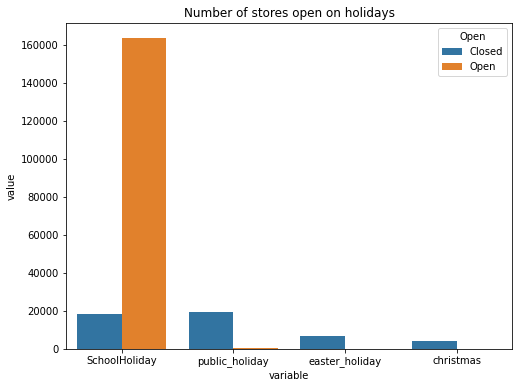

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x='variable',y='value',data=store_holiday_df,hue='Open')
plt.title('Number of stores open on holidays')

For the linear regression model, we need to provide data in normal distribution to make accurate predictions. Let's plot distribution graphs.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85c8337690>,
      dtype=object)

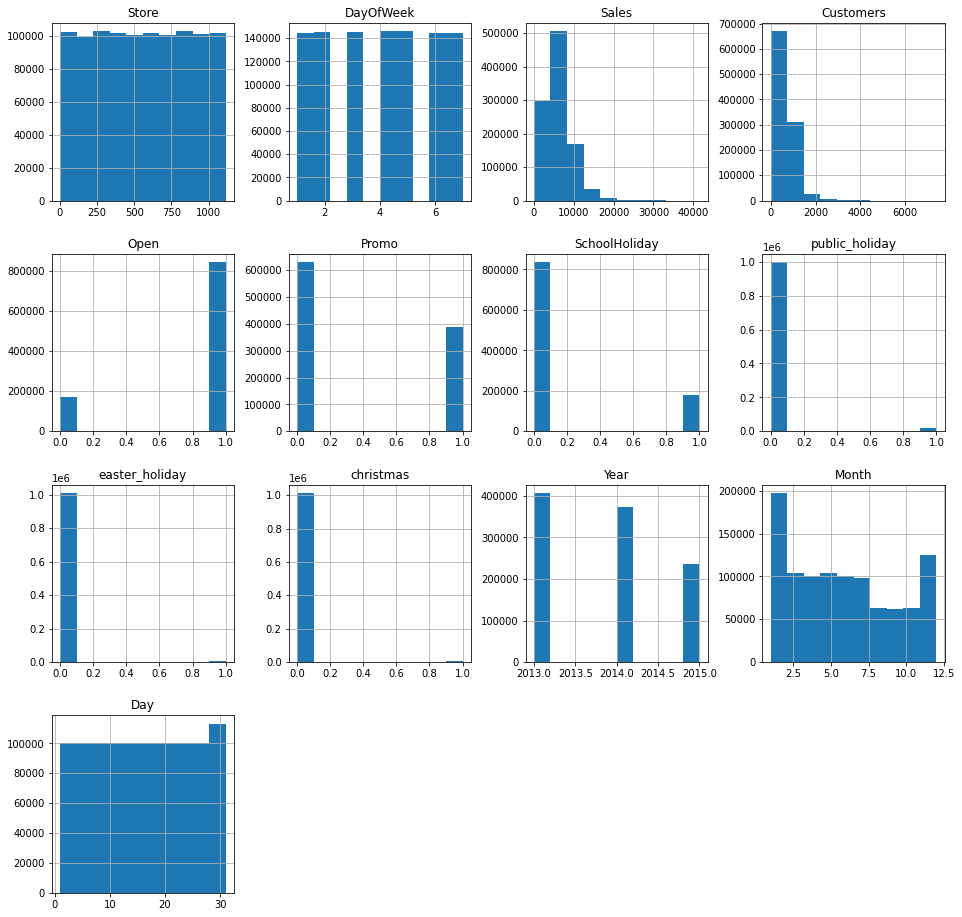

In [ ]:
# plot the distribution of values
store_data_df.hist(figsize=(16,16))

Sales and Customer data are right-skewed. We can log transform the data to remove this skewness.

In [ ]:
# Log transforming features
store_data_df['Sales_log_t'] = store_data_df['Sales'].apply(lambda x: np.log(x+1))
store_data_df['Customers_log_t'] = store_data_df['Customers'].apply(lambda x: np.log(x+1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85bbe18ed0>,
      dtype=object)

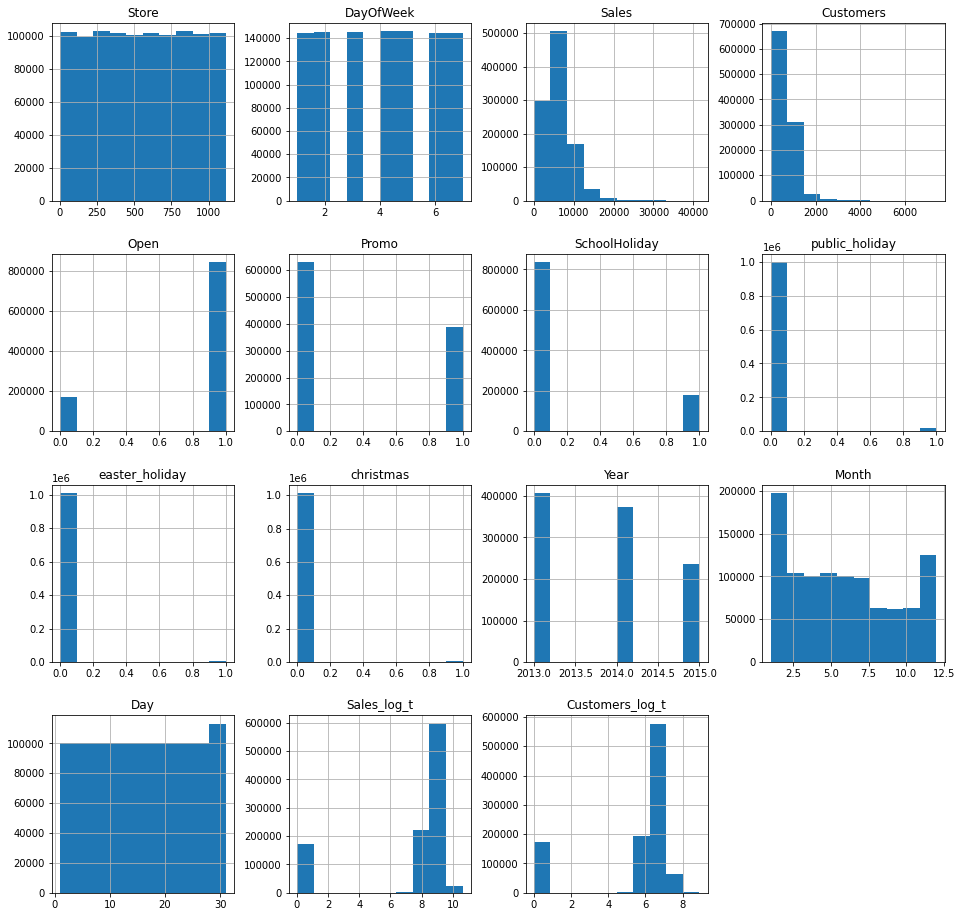

In [ ]:
store_data_df.hist(figsize=(16,16))

Let's check the relationship between sales and customer data.

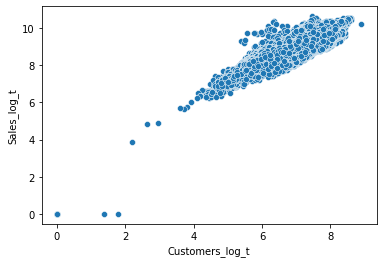

In [ ]:
# plot relation between sales and customer
sns.scatterplot(data=store_data_df,x='Customers_log_t',y='Sales_log_t')

Let's check the correlation between each variable.

Text(0.5, 1.0, 'Correlation matrix')

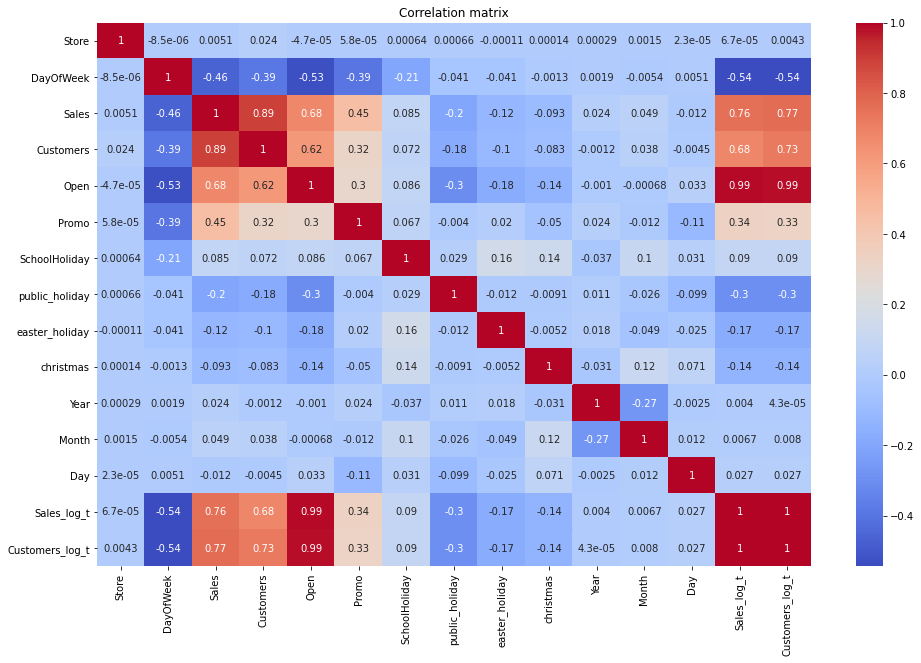

In [ ]:
# plot correlation matrix
plt.figure(figsize=(16,10))
sns.heatmap(store_data_df.corr(),annot=True,cmap='coolwarm')
plt.title('Correlation matrix')

We can see that some features have a high correlation. We need to remove this multicollinearity, but before we feed this data to our linear regression model we need to combine our datasets.

We need to merge the data based on store id to form a single dataset.

In [ ]:
# merge datasets
sales_df = pd.merge(left=store_data_df, right=store_df, on='Store')
sales_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day,Sales_log_t,Customers_log_t,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval1,PromoInterval2,PromoInterval3,Store_Type,Assortment_Level
0,1,5,5263,555,1,1,1,0,0,0,2015,7,31,8.568646,6.320768,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,3,1
1,1,4,5020,546,1,1,1,0,0,0,2015,7,30,8.521384,6.304449,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,3,1
2,1,3,4782,523,1,1,1,0,0,0,2015,7,29,8.472823,6.261492,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,3,1
3,1,2,5011,560,1,1,1,0,0,0,2015,7,28,8.519590,6.329721,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,3,1
4,1,1,6102,612,1,1,1,0,0,0,2015,7,27,8.716536,6.418365,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,3,1


Now that we have a dataset, we can prepare it for our model.

We have promo2 information that is a consecutive promotional offer that runs for a month at 2 months interval. But how we can use this information?

Well, we have information about the date so we can calculate if promo2 is running on the particular date. This binary value will be useful information for training our model. 

In [ ]:
# updating promo2 for given date
def continuous_promotion(data):
  promo_month = False
  # promo2 is valid for stores that participate in continuous and consecutive promotion
  if data['Promo2'] == 1:
    # promotion should be running on current month
    current_month = data['Month']
    if ((current_month % 3 == 1) and (data['PromoInterval1'] == 1)):
      promo_month = True
    if ((current_month % 3 == 2) and (data['PromoInterval2'] == 1)):
      promo_month = True
    if ((current_month % 3 == 0) and (data['PromoInterval3'] == 1)):
      promo_month = True
    # if current moth is promo month then promotion should start before current date
    if promo_month:
      if (data['Year'] > data['Promo2SinceYear']):
        # promo2 start before current year
        return 1
      if (data['Year'] == data['Promo2SinceYear']):
        # promo2 start on this year
        if (current_month > ((data['Promo2SinceWeek']//4)+1)):
          # promo2 start before current month
          return 1
  return 0

In [ ]:
# combine features for promo2
sales_df['Promo_cont'] = sales_df.apply(continuous_promotion, axis=1)

In [ ]:
# remove columns
sales_df.drop(columns=['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3'], inplace=True)

In [ ]:
sales_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day,Sales_log_t,Customers_log_t,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Store_Type,Assortment_Level,Promo_cont
0,1,5,5263,555,1,1,1,0,0,0,2015,7,31,8.568646,6.320768,1270.0,9.0,2008.0,3,1,0
1,1,4,5020,546,1,1,1,0,0,0,2015,7,30,8.521384,6.304449,1270.0,9.0,2008.0,3,1,0
2,1,3,4782,523,1,1,1,0,0,0,2015,7,29,8.472823,6.261492,1270.0,9.0,2008.0,3,1,0
3,1,2,5011,560,1,1,1,0,0,0,2015,7,28,8.519590,6.329721,1270.0,9.0,2008.0,3,1,0
4,1,1,6102,612,1,1,1,0,0,0,2015,7,27,8.716536,6.418365,1270.0,9.0,2008.0,3,1,0


We have information about competition start time, but how it is useful in the training linear regression model?

Model predictions work better if we provide data with continuous variables. So, how do we turn the competition start date into a continuous variable?

Well, we have the date of data collection, based on that we can calculate how many days have passed since the competition opened. Now this competition time is a continuous variable that we can use for model training.

In [ ]:
# Function for removing the collinearity by converting to quantitative data of CompetitionOpenSinceYear and CompetitionOpenSinceMonth
def CompitionOpenTimeInDays(row):
  # check if competition exist
  if row['CompetitionOpenSinceYear'] == 0:
    return 0
  compitition_start_date = date(int(row['CompetitionOpenSinceYear']),int(row['CompetitionOpenSinceMonth']),1) # add 1 as day indicating start of month
  competetion_time = date(int(row['Year']), int(row['Month']), int(row['Day'])) - compitition_start_date
  # check if competition time exist
  if competetion_time.days <= 0:
    return 0
  return competetion_time.days

In [ ]:
# create new featue competition time 
sales_df['CompetitionTime']=sales_df.apply(CompitionOpenTimeInDays,axis=1)
# remove old columns
sales_df.drop(columns=['CompetitionOpenSinceYear','CompetitionOpenSinceMonth'],inplace=True)

In [ ]:
sales_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day,Sales_log_t,Customers_log_t,CompetitionDistance,Store_Type,Assortment_Level,Promo_cont,CompetitionTime
0,1,5,5263,555,1,1,1,0,0,0,2015,7,31,8.568646,6.320768,1270.0,3,1,0,2524
1,1,4,5020,546,1,1,1,0,0,0,2015,7,30,8.521384,6.304449,1270.0,3,1,0,2523
2,1,3,4782,523,1,1,1,0,0,0,2015,7,29,8.472823,6.261492,1270.0,3,1,0,2522
3,1,2,5011,560,1,1,1,0,0,0,2015,7,28,8.519590,6.329721,1270.0,3,1,0,2521
4,1,1,6102,612,1,1,1,0,0,0,2015,7,27,8.716536,6.418365,1270.0,3,1,0,2520


Let's check the correlation between each variable.

Text(0.5, 1.0, 'Correlation matrix')

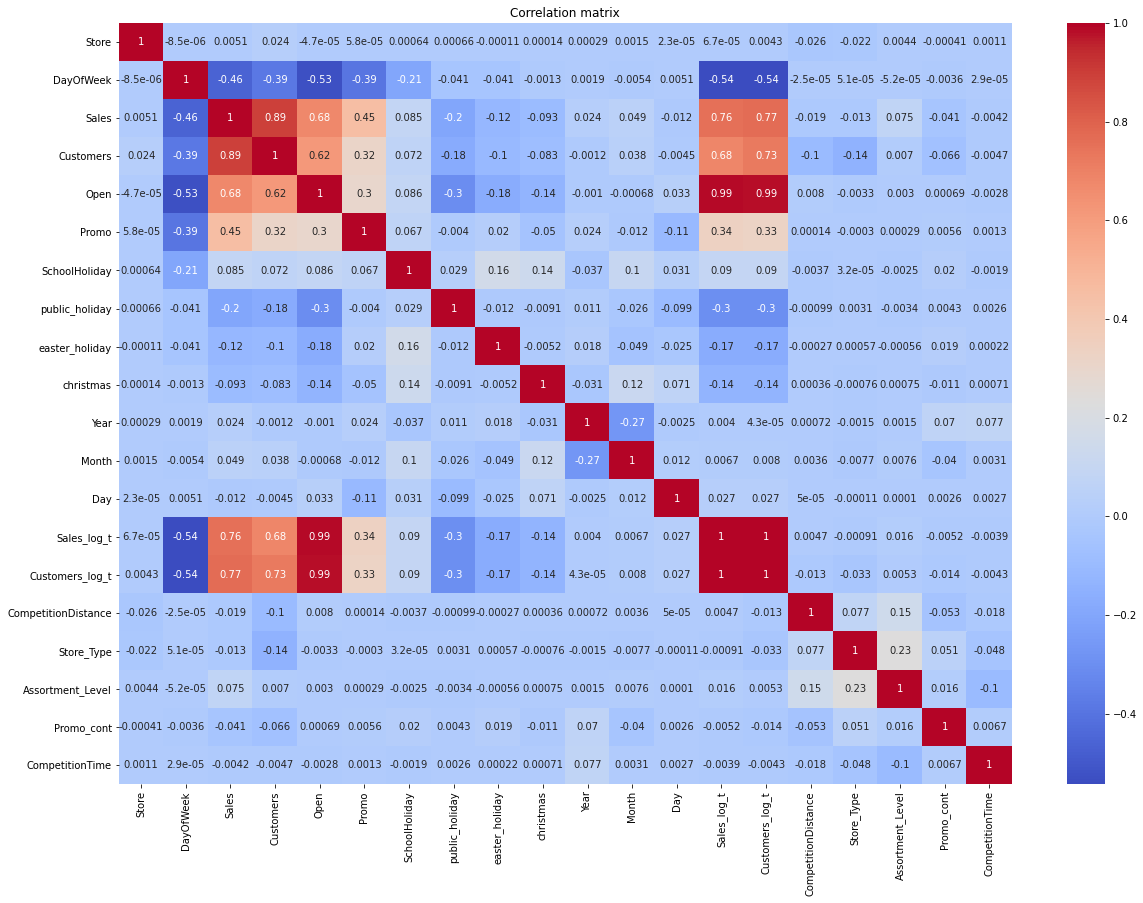

In [ ]:
# plot correlation matrix
plt.figure(figsize=(20,14))
sns.heatmap(sales_df.corr(),annot=True,cmap='coolwarm')
plt.title('Correlation matrix')

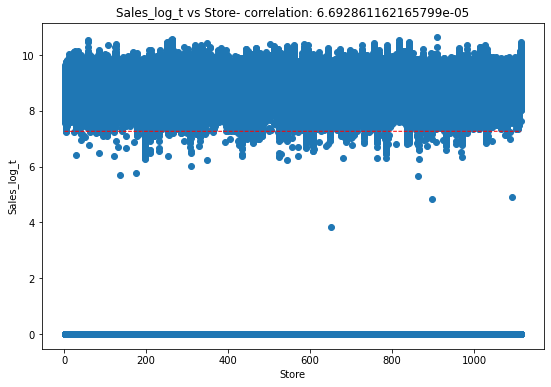

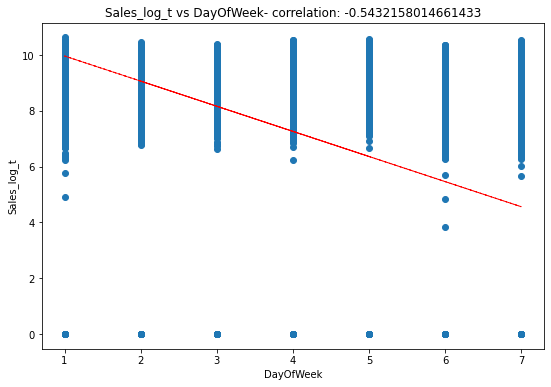

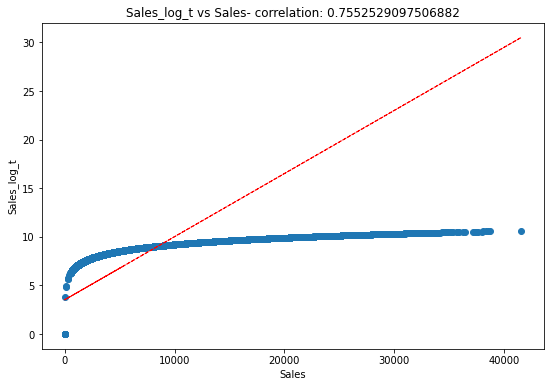

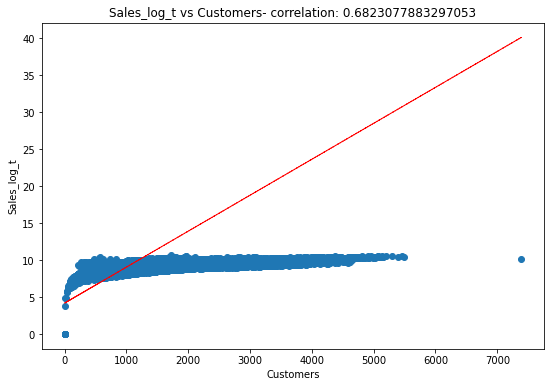

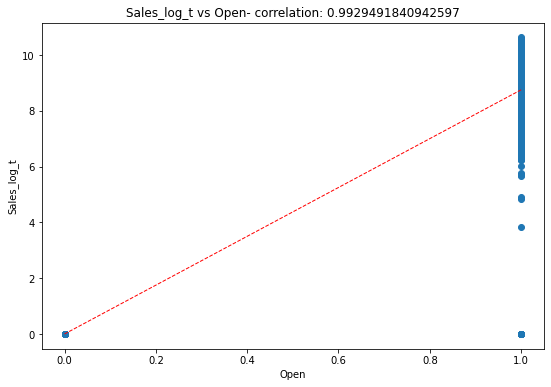

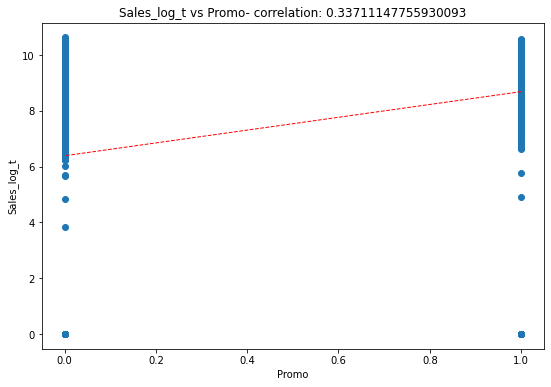

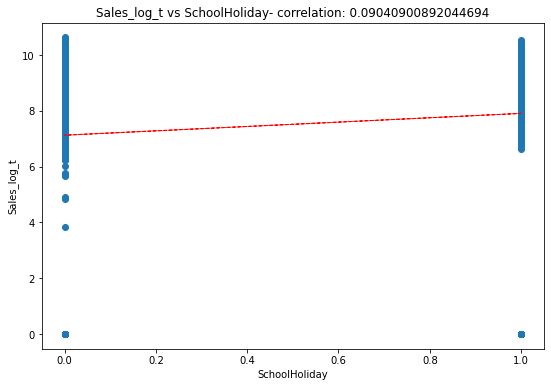

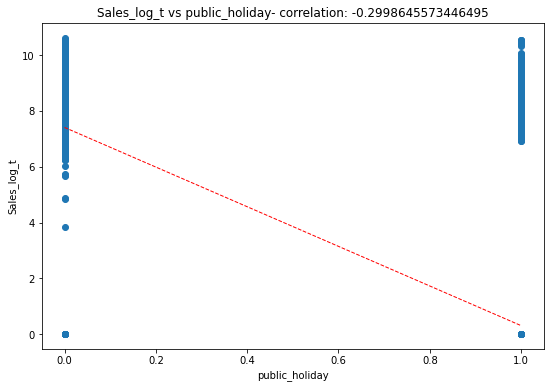

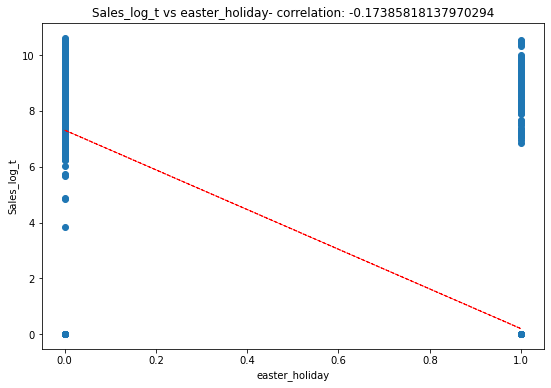

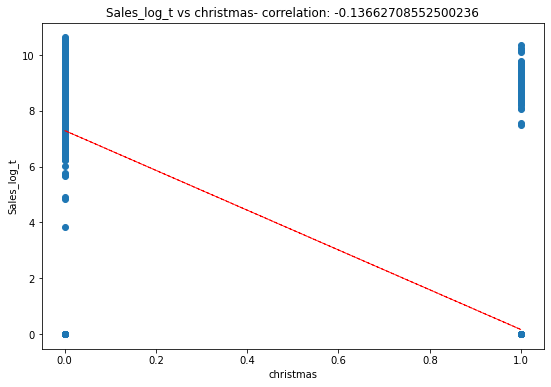

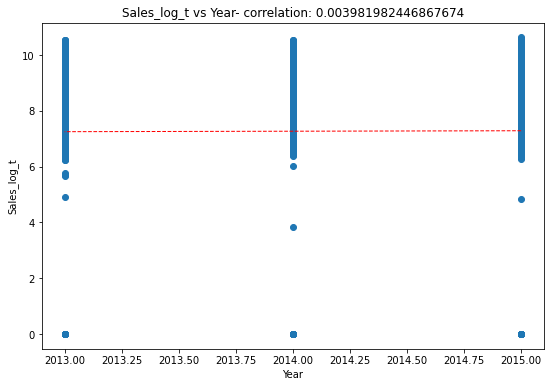

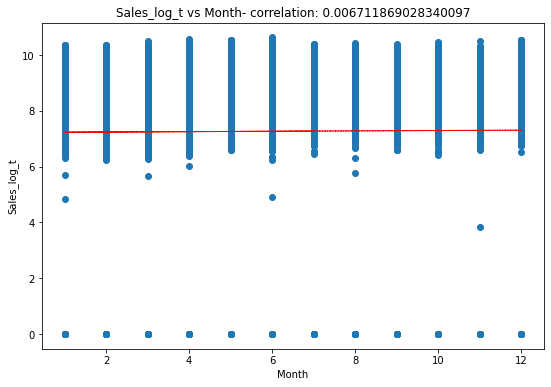

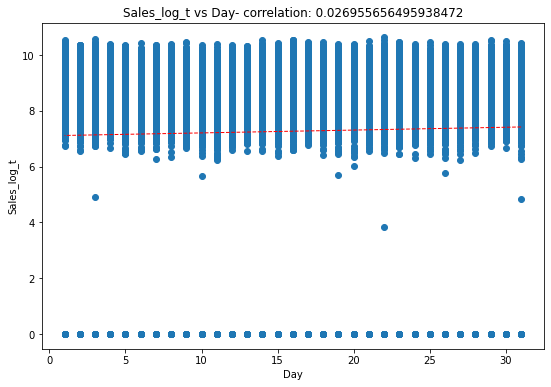

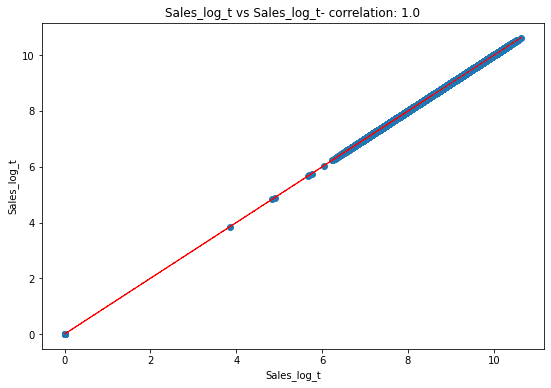

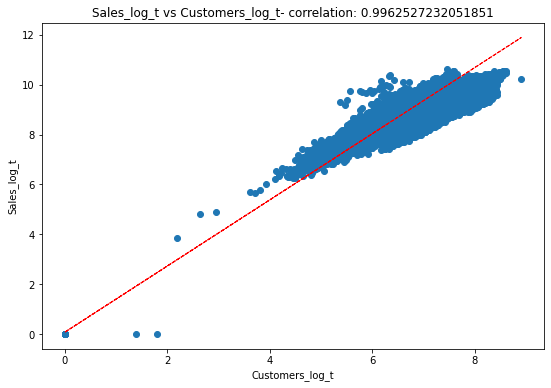

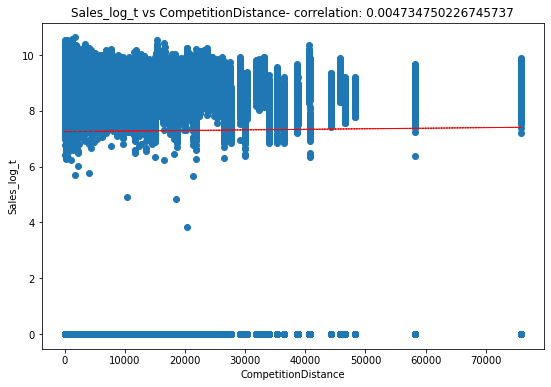

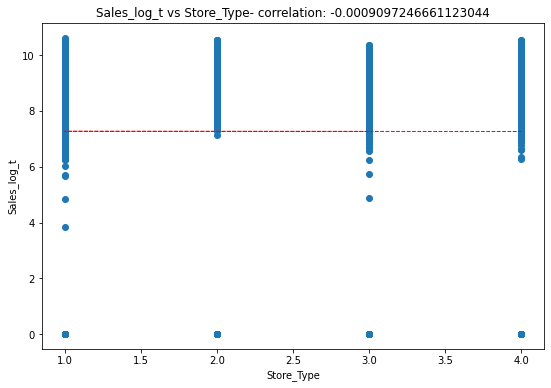

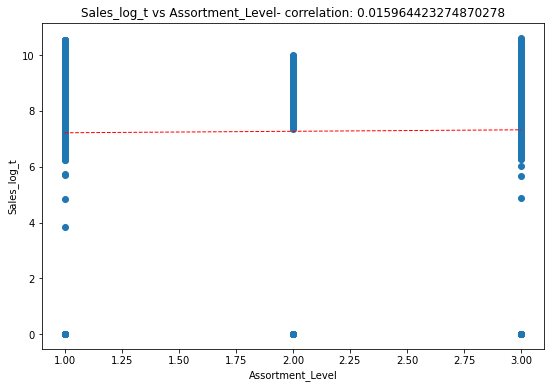

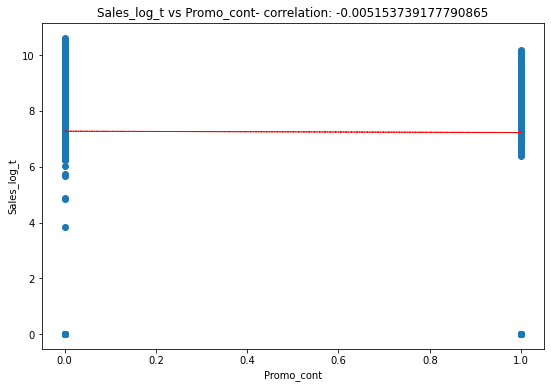

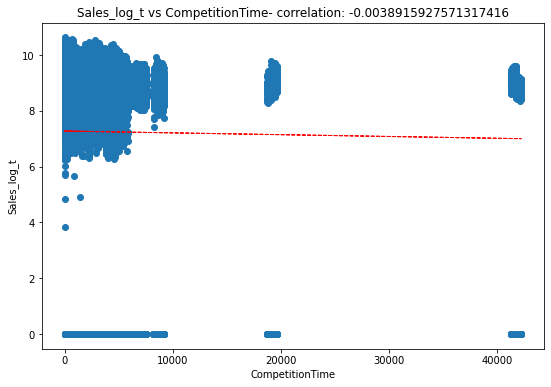

In [ ]:
for col in sales_df:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = sales_df[col]
    label = sales_df['Sales_log_t']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Sales_log_t')
    ax.set_title('Sales_log_t vs ' + col + '- correlation: ' + str(correlation))
    z = np.polyfit(sales_df[col], sales_df['Sales_log_t'], 1)
    y_hat = np.poly1d(z)(sales_df[col])

    plt.plot(sales_df[col], y_hat, "r--", lw=1)

plt.show()

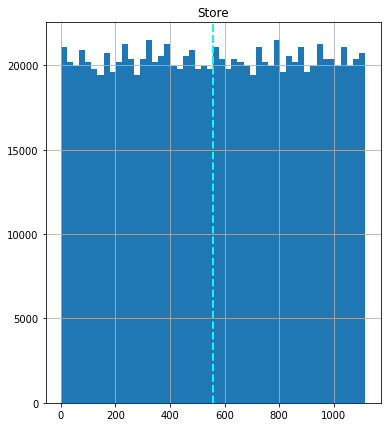

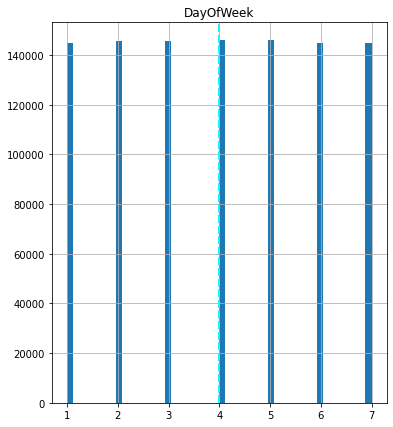

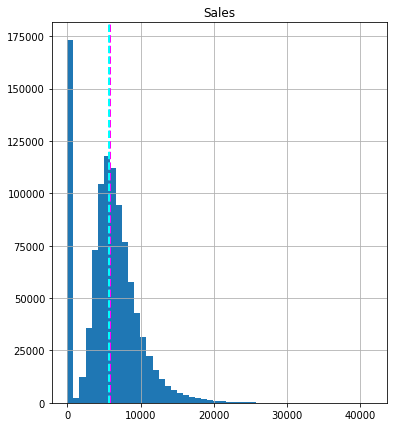

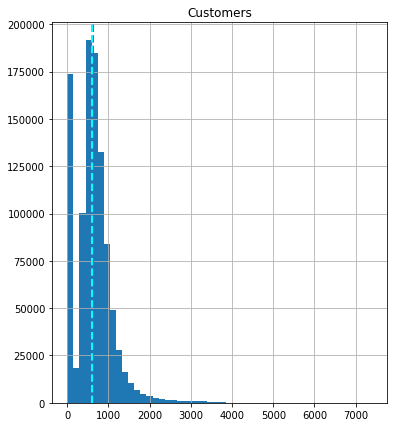

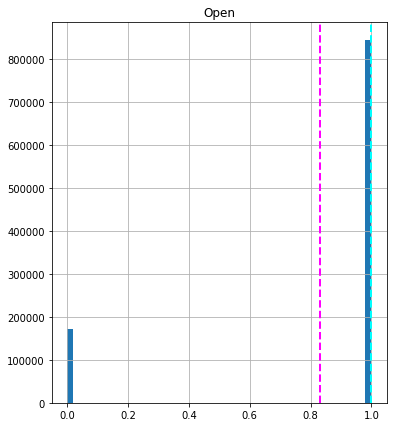

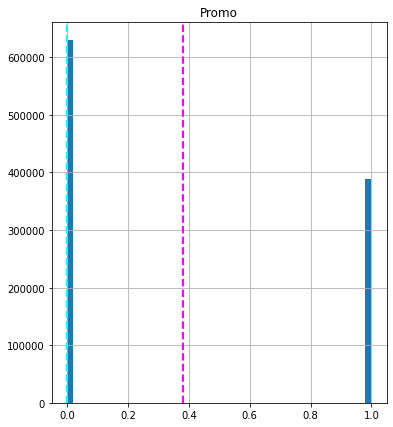

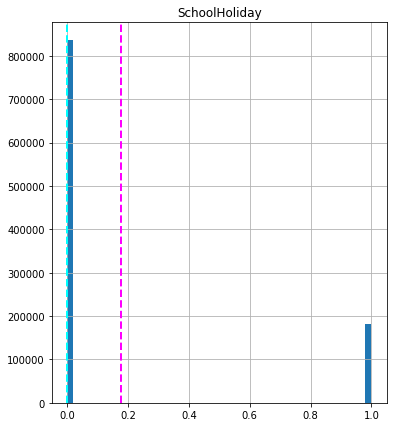

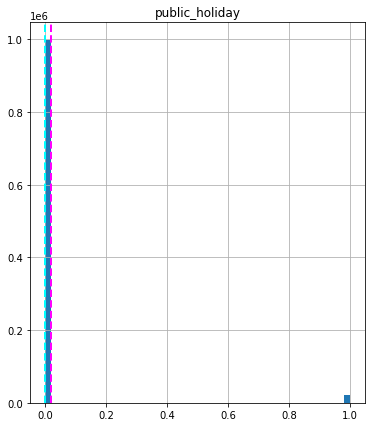

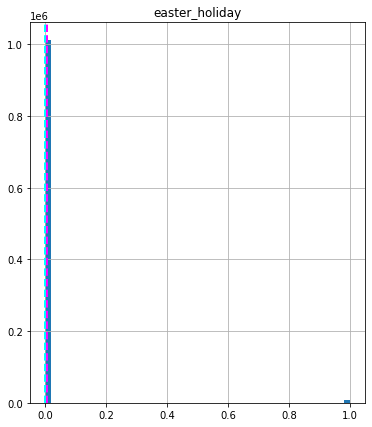

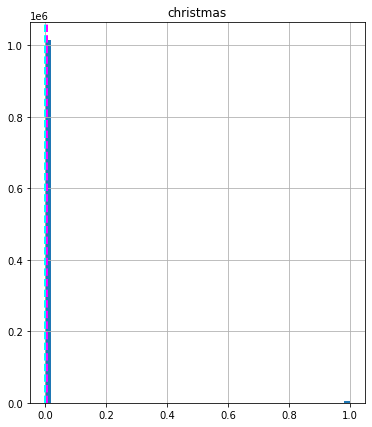

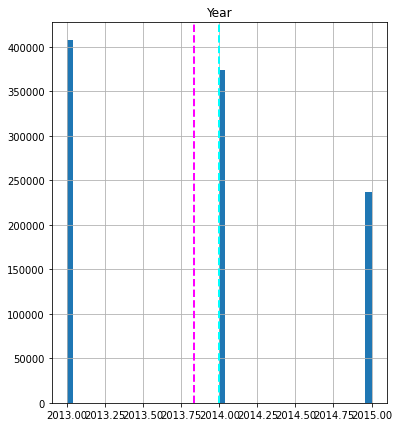

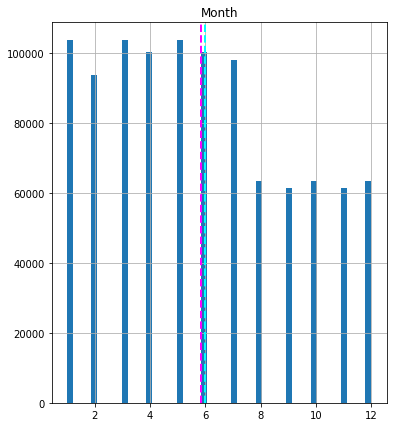

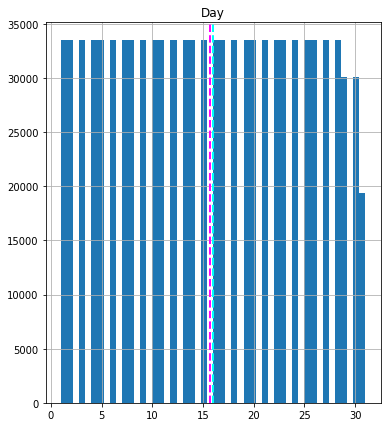

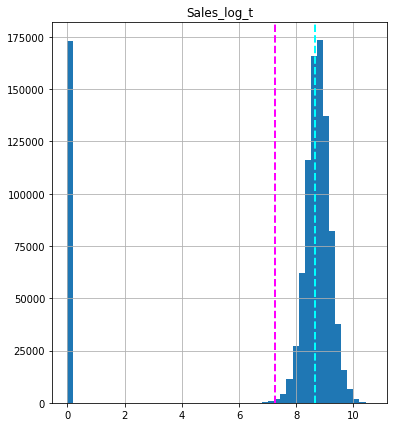

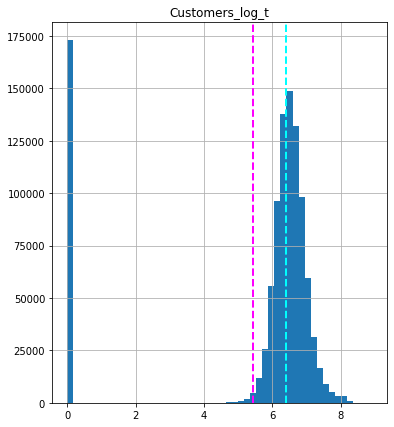

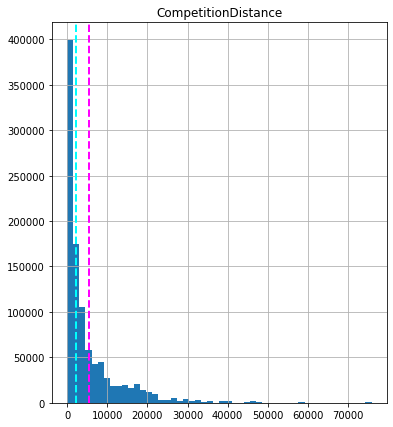

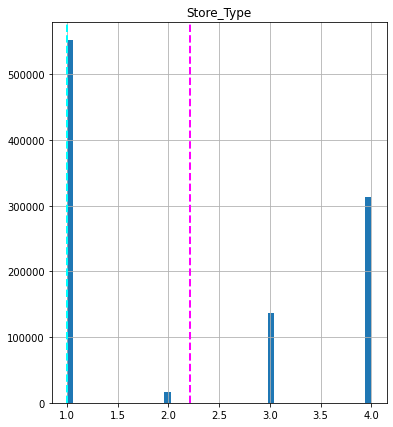

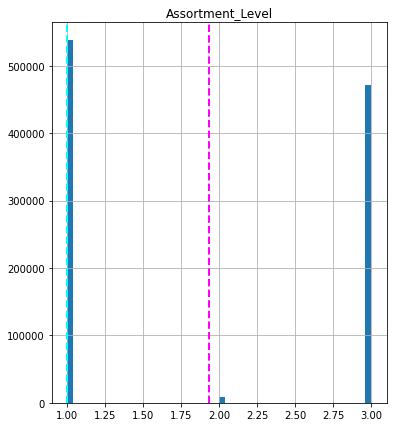

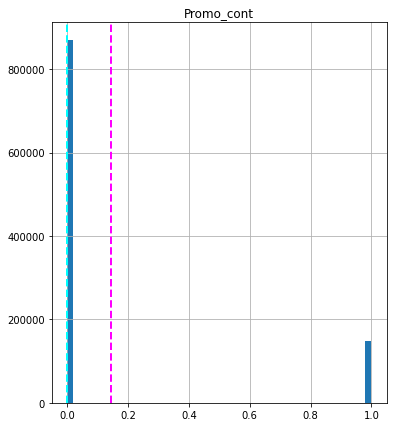

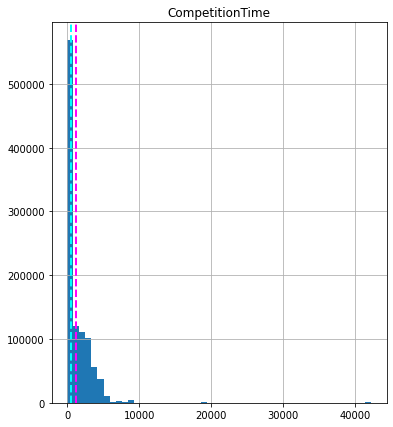

In [ ]:
for col in sales_df:
  figure=plt.figure(figsize=(6,7))
  ax=figure.gca()
  feature = sales_df[col]
  feature.hist(bins=50, ax = ax)
  ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
  ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
  ax.set_title(col)
plt.show()

We can see that there is a high correlation between some variables. We need to remove this multicollinearity.

**Removing Multicollinearity**

In [ ]:
# function to calculate VIF
def calculate_vif(data):
  vif = pd.DataFrame()
  vif["variables"] = data.columns
  vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
  return vif

In [ ]:
calculate_vif(sales_df.drop(columns=['Sales','Customers','Sales_log_t']))

,variables,VIF
0,Store,4.016097
1,DayOfWeek,8.588702
2,Open,249.549734
3,Promo,2.066414
4,SchoolHoliday,1.348287
5,public_holiday,1.235592
6,easter_holiday,1.120277
7,christmas,1.080406
8,Year,44.109260
9,Month,4.219404


We can see there are very high variation inflation factors. Let's try to remove some columns to reduce VIF.

In [ ]:
calculate_vif(sales_df.drop(columns=['Sales','Customers','Year','Sales_log_t', 'Customers_log_t']))

,variables,VIF
0,Store,3.730827
1,DayOfWeek,4.452981
2,Open,6.191915
3,Promo,1.872410
4,SchoolHoliday,1.342025
5,public_holiday,1.099311
6,easter_holiday,1.074031
7,christmas,1.072576
8,Month,3.904310
9,Day,3.965944


Now we have VIF less than 7. So, we can drop unuseful columns and start building linear regression model.

#2. Model Building

Split the data by date to test the model predictions.
We will use the last 6 weeks' data as the test case for our model.
So, we will train our model on the remaining data.

In [ ]:
# split the dataset in 2 by dates, for test on last 6 weeks
# first sort the model data 
sorted_sales_df = sales_df.sort_values(by=['Year','Month','Day'],ascending=False)
sorted_sales_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day,Sales_log_t,Customers_log_t,CompetitionDistance,Store_Type,Assortment_Level,Promo_cont,CompetitionTime
0,1,5,5263,555,1,1,1,0,0,0,2015,7,31,8.568646,6.320768,1270.0,3,1,0,2524
942,2,5,6064,625,1,1,1,0,0,0,2015,7,31,8.710290,6.439350,570.0,1,1,1,2829
1884,3,5,8314,821,1,1,1,0,0,0,2015,7,31,9.025816,6.711740,14130.0,1,1,1,3164
2826,4,5,13995,1498,1,1,1,0,0,0,2015,7,31,9.546527,7.312553,620.0,3,3,0,2159
3768,5,5,4822,559,1,1,1,0,0,0,2015,7,31,8.481151,6.327937,29910.0,1,1,0,121


In [ ]:
# get split date
last_date = date(int(sorted_sales_df.iloc[0]['Year']),int(sorted_sales_df.iloc[0]['Month']),int(sorted_sales_df.iloc[0]['Day'])) 
last_loc = len(sorted_sales_df) - 1
first_date = date(int(sorted_sales_df.iloc[last_loc]['Year']),int(sorted_sales_df.iloc[last_loc]['Month']),int(sorted_sales_df.iloc[last_loc]['Day']))
split_date = last_date - timedelta(6*7) # remove 6 weeks from last date of data
split_date 

datetime.date(2015, 6, 19)

In [ ]:
# find index of split date
index = 0
for i in range(len(sorted_sales_df)):
  year = int(sorted_sales_df.iloc[i]['Year'])
  month = int(sorted_sales_df.iloc[i]['Month'])
  day = int(sorted_sales_df.iloc[i]['Day'])
  if ((year == split_date.year) and (month == split_date.month) and (day == split_date.day)):
    index = i
    break
print(index)

46830


In [ ]:
# split the data from the split date
test_data = sorted_sales_df.iloc[:46830].sample(frac = 1)  # taking sample with fract=1 will arrange data in random order
train_data = sorted_sales_df.iloc[46830:].sample(frac = 1)
print(train_data.shape, test_data.shape)

(970379, 20) (46830, 20)


Now we have a training dataset and test dataset. So, we train our model on the training dataset. and after training, we can use the test dataset to evaluate our model performance.

In [ ]:
# declare dependent varaible
dependent_variable = 'Sales_log_t'

In [ ]:
# Create a list of independent variables
# remove variables that have high VIF
columns_to_drop = ['Sales','Customers','Year','Sales_log_t', 'Customers_log_t']
independent_variables = list(set(sales_df.columns.tolist()) - set(columns_to_drop))
independent_variables

['Store_Type',
 'Store',
 'DayOfWeek',
 'public_holiday',
 'easter_holiday',
 'CompetitionTime',
 'Assortment_Level',
 'Promo',
 'christmas',
 'CompetitionDistance',
 'Open',
 'Promo_cont',
 'Month',
 'Day',
 'SchoolHoliday']

In [ ]:
# create traininig and test set
train_data_independent_variables = train_data.drop(columns=columns_to_drop)
test_data_independent_variables = test_data.drop(columns=columns_to_drop)
train_data_dependent_variable = train_data[dependent_variable]
test_data_dependent_variable = test_data[dependent_variable]

X_train = train_data_independent_variables.values
X_test = test_data_independent_variables.values
y_train = train_data_dependent_variable.values
y_test = test_data_dependent_variable.values

Before feeding the data to model, we should scale it. This reduces computation cost.

In [ ]:
# Transforming data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Building linear regression model

Let's start with building a linear regression model with default hyperparameters.

In [ ]:
# build the regression model with default hyper parameters
regressor = LinearRegression()
# train the model with training data set
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
regressor.intercept_

0.07188030354881647

In [ ]:
regressor.coef_

array([-7.61056417e-04, -1.22838333e-01,  8.54828291e+00,  3.12333760e-01,
        1.69162209e-02, -1.74944079e-01, -2.23372755e-01, -1.07104519e-01,
        7.73650058e-02, -1.79895719e-02, -1.82370512e-01, -1.41869309e-03,
        9.11216817e-02, -5.99519711e-02,  7.86539605e-03])

In [ ]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)

**Model Evaluation**

After training the model we need to evaluate the model based on predictions.
We will evaluate the model on different metrics.

We have trained the model on 14 features. Since adding more features always increase the R-square score, we are also evaluating model on Adjusted R-square score.

In [ ]:
# Function to check for Evaluation Metrics
def mean_absolute_percentage_error(actual, pred):
  error_term = actual - pred
  num_of_observation = len(error_term)
  sum = 0
  for i in range(num_of_observation):
    if actual[i] != 0:
      sum = sum + abs(error_term[i]/actual[i])
    else:
      sum = sum + abs(error_term[i])
  return sum*100/num_of_observation

def evaluation_metrics(actual, pred, num_of_features=0):
  MSE = mean_squared_error (actual , pred)
  print('Mean Squared Error :' , round(MSE,2))
  print('Root Mean Squared Error :' , round(np.sqrt(MSE)))
  error_term = actual - pred
  num_of_observation = len(error_term)
  MAE = sum(abs(error_term))/num_of_observation
  print('Mean Absolute Error :' , round(MAE,2))
  print('Mean Absolute Percentage Error :' , round(mean_absolute_percentage_error(actual, pred),2), '%')
  R2 = r2_score(actual , pred)
  print('R-Square :' , round(R2,2)) 
  if num_of_features > 0:
    adj_r2 = 1-(1-R2)*((num_of_observation-1)/(num_of_observation-num_of_features-1))
    print("Adjusted R-Square : ", round(adj_r2, 2))

In [ ]:
# Evaluating Linear Reegression model
evaluation_metrics(y_test , y_pred, len(independent_variables))

Mean Squared Error : 0.11
Root Mean Squared Error : 0
Mean Absolute Error : 0.25
Mean Absolute Percentage Error : 3.41 %
R-Square : 0.99
Adjusted R-Square :  0.99


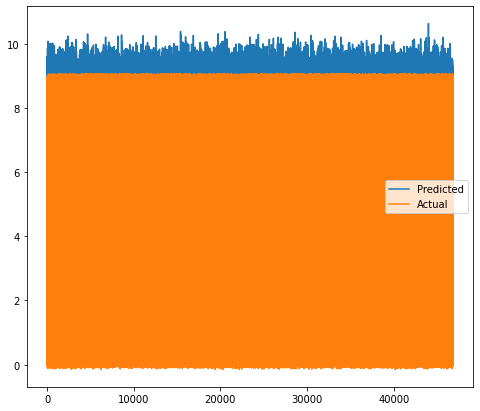

In [ ]:
#Plot between actual and predicted
plt.figure(figsize=(8,7))
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(["Predicted" , "Actual"])
plt.show()

**Checking the assumptions of Linear Regression**

We are using linear regression model so, we need to check 4 basic assumptions of linear regression.

1. There need to be linear relationship between independent and dependent variables
2. The sum of residuals should be near 0
3. There should not be multicollinearity
4. These should not be heteroscedasticity

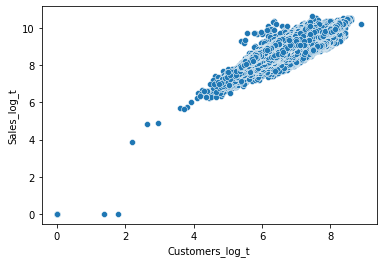

In [ ]:
# Plotting the relationship between sales and customer
sns.scatterplot(data=sales_df,x='Customers_log_t',y='Sales_log_t')

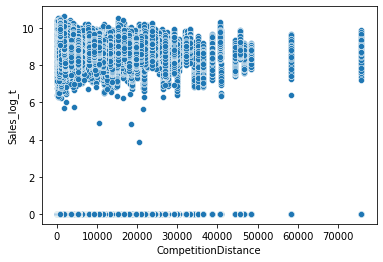

In [ ]:
# Plotting the relationship between Sales and Competition Distance
sns.scatterplot(data=sales_df,x='CompetitionDistance',y='Sales_log_t')

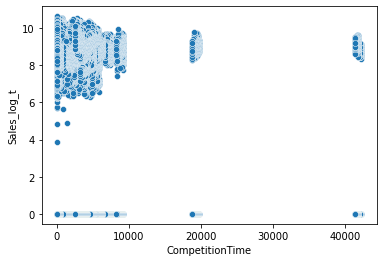

In [ ]:
# Plotting the relationship between Sales and Compition Open Since Number Of Days
sns.scatterplot(data=sales_df,x='CompetitionTime',y='Sales_log_t')

In [ ]:
# Checking the mean of Residuals
sum(y_pred-y_test)/ len(sales_df)

-0.000706463461924401

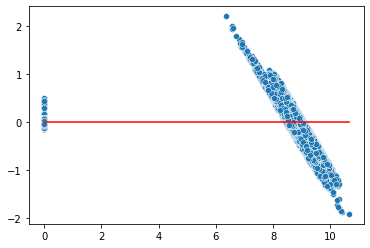

In [ ]:
# Checking Homoscedasticity
error_terms = y_pred-y_test
plot = sns.scatterplot(x=y_test,y=error_terms)
# plot.map_dataframe(plot_hline,y=0)
plt.plot([0,max(y_test)], [0,0], 'r-')

**Regularization**

We have evaluated our model and it's performing well. But does it overfitting to data? 

To answer that, let's implement some regularization.

**Implementing Lasso Regression**

First, we will implement Lasso to penalize on L1 norm.

In [ ]:
# create lasso regression model
lasso = Lasso(alpha = 0.1 , max_iter = 3000)
# train the model
lasso.fit(X_train , y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=3000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
lasso.score(X_train , y_train)

0.9801265464192069

In [ ]:
# predict the result
y_pred_lasso = lasso.predict(X_test)

In [ ]:
#Evaluation metrics for Lasso Regression
evaluation_metrics(y_test , y_pred_lasso, len(independent_variables))

Mean Squared Error : 0.2
Root Mean Squared Error : 0
Mean Absolute Error : 0.37
Mean Absolute Percentage Error : 11.38 %
R-Square : 0.98
Adjusted R-Square :  0.98


**Running Grid Search Cross Validation for Lasso Regression**

We can see that error rate is slightly increasing and R-square score decreased a little.

Let's try to find out best learning rate for Lasso Regression using Grid Search with Cross-Validation.

In [ ]:
#cross validation
lasso = Lasso()
parameters = {'alpha': [1e-10,1e-8,1e-5,1e-3,1e-1,1]}
lasso_regressor = GridSearchCV(lasso , parameters , scoring='neg_mean_squared_error' , cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-10, 1e-08, 1e-05, 0.001, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
# check the best value of learning rate
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-05}

Using  {'alpha': 1e-05}  the negative mean squared error is:  -0.12660595645533487


In [ ]:
# predict the result
y_pred_lasso_cv = lasso_regressor.predict(X_test)

In [ ]:
#Evaluation metrics for Lasso Regression with cross validation
evaluation_metrics(y_test , y_pred_lasso_cv, X_test.shape[1])

Mean Squared Error : 0.11
Root Mean Squared Error : 0
Mean Absolute Error : 0.25
Mean Absolute Percentage Error : 3.41 %
R-Square : 0.99
Adjusted R-Square :  0.99


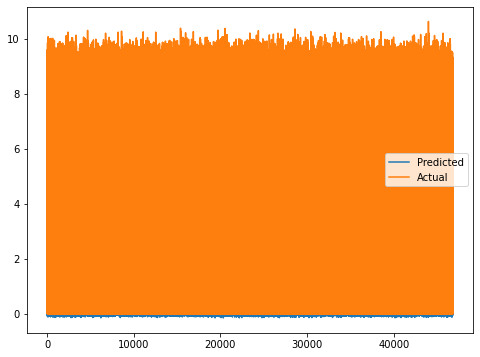

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(y_pred_lasso_cv)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

We can see that tuning the learning rate increases the evaluation scores.

Now let's try to use L2 norm of regularization.

**Implementing Ridge Regression**

In [ ]:
# create ridge regression model
ridge  = Ridge(alpha=0.1)
# train the model
ridge.fit(X_train,y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
ridge.score(X_train, y_train)

0.9885345334700549

In [ ]:
# predict the result
y_pred_ridge = ridge.predict(X_test)

In [ ]:
#Evaluation metrics for Ridge Regression
evaluation_metrics(y_test , y_pred_ridge, len(independent_variables))

Mean Squared Error : 0.11
Root Mean Squared Error : 0
Mean Absolute Error : 0.25
Mean Absolute Percentage Error : 3.41 %
R-Square : 0.99
Adjusted R-Square :  0.99


**Running Grid Search Cross Validation for Ridge Regression**

In [ ]:
#cross validation
ridge = Ridge()
parameters = {'alpha': [1e-5,1e-3,1e-1,1]}
ridge_regressor = GridSearchCV(ridge , parameters , scoring='neg_mean_squared_error' , cv=5)
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-05, 0.001, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
# check the best value of learning rate
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", ridge_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 0.1}

Using  {'alpha': 0.1}  the negative mean squared error is:  -0.12660621076882167


In [ ]:
# predict the result
y_pred_ridge_cv = ridge_regressor.predict(X_test)

In [ ]:
#Evaluation metrics for Ridge Regression with cross validation
evaluation_metrics(y_test , y_pred_ridge_cv, len(independent_variables))

Mean Squared Error : 0.11
Root Mean Squared Error : 0
Mean Absolute Error : 0.25
Mean Absolute Percentage Error : 3.41 %
R-Square : 0.99
Adjusted R-Square :  0.99


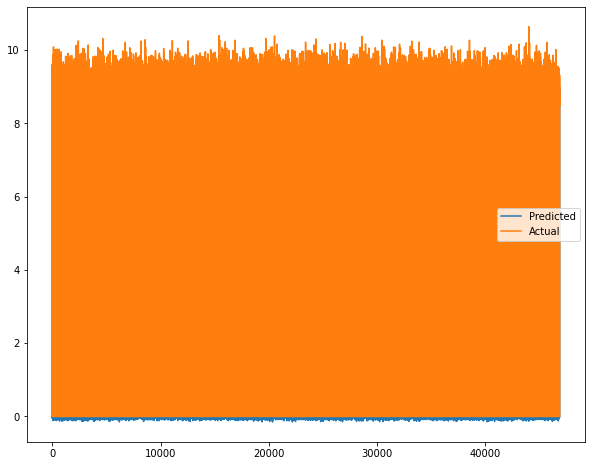

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(y_pred_ridge_cv)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

**Implementing Elastic net Regression**

In [ ]:
# Build elastic net regression model
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)
# treain the moodel
elasticnet.fit(X_train,y_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
elasticnet.score(X_train, y_train)

0.9093272842926423

In [ ]:
# predict the result from elastic net model
y_pred_en = elasticnet.predict(X_test)

In [ ]:
#Evaluation metrics for Elastic Net Regression
evaluation_metrics(y_test , y_pred_en, len(independent_variables))

Mean Squared Error : 0.8
Root Mean Squared Error : 1
Mean Absolute Error : 0.68
Mean Absolute Percentage Error : 30.75 %
R-Square : 0.91
Adjusted R-Square :  0.91


**Running Grid Search Cross Validation for Elastic Net Regression**

In [ ]:
#cross validation
elastic = ElasticNet()
parameters = {'alpha': [1e-10,1e-8,1e-5,1e-3,1e-1,1]}
elastic_regressor = GridSearchCV(elastic , parameters , scoring='neg_mean_squared_error' , cv=5)
elastic_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-10, 1e-08, 1e-05, 0.001, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
# check the best value of learning rate
print("The best fit alpha value is found out to be :" ,elastic_regressor.best_params_)
print("\nUsing ",elastic_regressor.best_params_, " the negative mean squared error is: ", elastic_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-05}

Using  {'alpha': 1e-05}  the negative mean squared error is:  -0.1266060352693687


In [ ]:
# predict the result
y_pred_en_cv = elastic_regressor.predict(X_test)

In [ ]:
#Evaluation metrics for Elastic Net Regression
evaluation_metrics(y_test , y_pred_en_cv, len(independent_variables))

Mean Squared Error : 0.11
Root Mean Squared Error : 0
Mean Absolute Error : 0.25
Mean Absolute Percentage Error : 3.41 %
R-Square : 0.99
Adjusted R-Square :  0.99


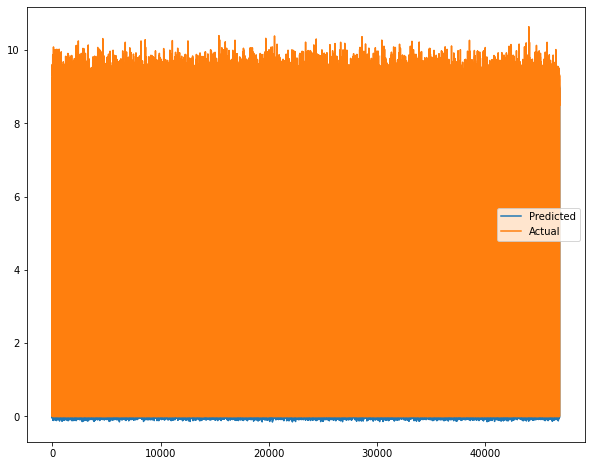

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(y_pred_en_cv)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

We have made 4 models. Sometimes it's useful to predict data on different models to increase accuracy of prediction and raise our confidence level.

Staking is a good way to combine all the predictions from different models into one. We can adjust weights for each model in stacking.

**Stack Model**

In [ ]:
# function to create average prediction of all models 
def stack_predict(test):
  # define weights for each model
  w_regresor = 1/4
  w_lasso = 1/4
  w_ridge = 1/4
  w_elastic = 1/4
  # get prediction from each model
  pred_regressor = regressor.predict(test)
  pred_lasso_cv = lasso_regressor.predict(test)
  pred_ridge_cv = ridge_regressor.predict(test)
  pred_en_cv = elastic_regressor.predict(test)
  # get weighted prediction
  w_pred = (w_regresor * pred_regressor) + (w_lasso * pred_lasso_cv) + (w_ridge * pred_ridge_cv) + (w_elastic * pred_en_cv)
  return w_pred

In [ ]:
# predict the result
y_pred_stack = stack_predict(X_test)

In [ ]:
# Evaluation metrics for Stack model
evaluation_metrics(y_test , y_pred_stack, len(independent_variables))

Mean Squared Error : 0.11
Root Mean Squared Error : 0
Mean Absolute Error : 0.25
Mean Absolute Percentage Error : 3.41 %
R-Square : 0.99
Adjusted R-Square :  0.99


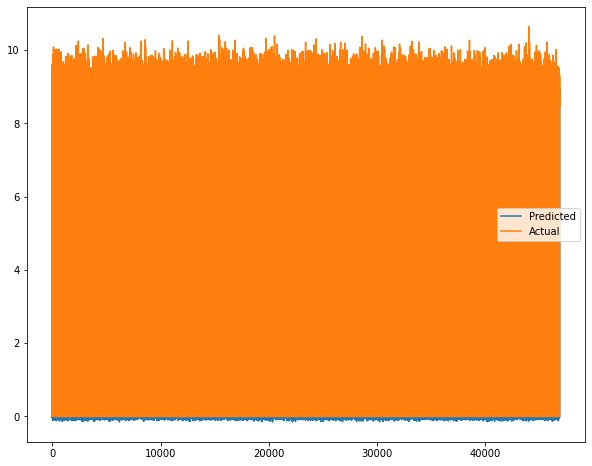

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(y_pred_stack)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

**Predicting Sales for next six weeks**

Now that we have linear regression models that performing well. we need to predict Sales for next 6 weeks in Advance.

To do that we need independent variables data to create X_test data set.
So we need to generate data for X_test and then we can use the data for prediction.

In [ ]:
train_data_independent_variables.head()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Month,Day,CompetitionDistance,Store_Type,Assortment_Level,Promo_cont,CompetitionTime
877833,963,4,1,1,0,0,0,0,8,29,23620.0,1,3,0,0
703358,773,7,0,0,0,0,0,0,6,7,200.0,1,1,0,0
507949,557,2,0,0,1,1,0,0,1,1,250.0,1,1,0,0
34713,38,3,1,0,0,0,0,0,6,12,1090.0,4,1,0,2264
989709,1085,2,1,0,0,0,0,0,12,10,4030.0,3,1,0,0


Our models are trained train_data_independent_variables dataset so we need to generate data with columns in the same order to predict sales on the generated data.

In [ ]:
# these functions uses train_data_independent_variables dataframe as reference dataframe
# function to check if there is a holiday on given date and holiday name

def get_holidays(ref_date, holiday):
  # check reference dataset for holidays
  # get first instance of each month and day

  df_group = train_data_independent_variables.groupby(['Month','Day']).first()
  # get array of values for given holiday

  val_array = df_group[holiday].values
  # convert given date to array of day_of_year

  day_of_year = ref_date.apply(lambda x: x.timetuple().tm_yday).values
  # return the array of holiday values for given date
  
  return val_array[day_of_year - 1] # remove 1 as array index start from 0

In [ ]:
# function to check if there is school holiday on given date
def get_school_holidays(ref_date):
  # schools have holidays on sunday and any of other holidays or have vacations
  # first get holidays as sundays

  sundays = ref_date.apply(lambda x: 1 if x.weekday() == 6 else 0) 
  # get school holidays from reference dataset

  holidays = get_holidays(ref_date, 'SchoolHoliday')
  school_holidays = []
  # create a loop to get school holidays
  
  for i in range(len(ref_date)):
    # if it's sunday then it's school holiday else get school holiday from refence dataset
    if sundays[i] == 1:
      school_holidays.append(1)
    else:
      school_holidays.append(holidays[i])
  return school_holidays

In [ ]:
# function to get reference value of given variable from the reference data set

def get_ref_value(store_ids, var_name):
  # first group reference dataset by store and get first instance of given variable as series
  # then convert it to array of values

  first_inst = train_data_independent_variables.groupby(['Store']).first()[var_name].values
  # now get array of result values by indexing from dataset
  
  return first_inst[store_ids - 1] # remove 1 as array index start from 0

In [ ]:
# function to get promo_cont from reference dataset

def get_promo_cont(store_ids, months):
  # first group reference dataset by store and month and get first instance of each group
  # then convert it to array of values for variable promo_cont

  values = train_data_independent_variables.groupby(['Store','Month']).first()['Promo_cont'].values
  # now get array of indices to get promo_count value

  indices = []
  month_values = months.values
  for index, id in enumerate(store_ids):
    # we have used groupby first on store and then months so values are arranged first by store then month
    # so we can get index by first multiplying store id with 12(total months) and then adding month value for
    # a particular store id
    
    index = ((id - 1)*12) + month_values[index] - 1  # remove 1 as array index start from 0
    indices.append(index)
  # return prmo_count values as array
  return values[indices]

In [ ]:
# function to get values for variable Open from reference dataset

def get_open(dataset):
  # we can calculate store being with probability values calculated from reference dataset
  # from EDA we can see that most stores are closed on public holiday, easter holiday and christmas
  # first calculate probabilities for each store being open on holidays

  store_open_public_holiday = train_data_independent_variables.groupby(['Store','public_holiday']).sum().iloc[1::2]['Open'].values
  store_total_public_holiday = train_data_independent_variables.groupby(['Store','public_holiday']).count().iloc[1::2]['Open'].values
  open_prob_public_holiday = store_open_public_holiday / store_total_public_holiday
  
  # easter holiday
  store_open_easter_holiday = train_data_independent_variables.groupby(['Store','easter_holiday']).sum().iloc[1::2]['Open'].values
  store_total_easter_holiday = train_data_independent_variables.groupby(['Store','easter_holiday']).count().iloc[1::2]['Open'].values
  open_prob_easter_holiday = store_open_easter_holiday / store_total_easter_holiday
  
  # christmas
  store_open_christmas = train_data_independent_variables.groupby(['Store','christmas']).sum().iloc[1::2]['Open'].values
  store_total_christmas = train_data_independent_variables.groupby(['Store','christmas']).count().iloc[1::2]['Open'].values
  open_prob_christmas = store_open_christmas / store_total_christmas
  
  # sundays
  store_open_sundays = train_data_independent_variables.groupby(['Store','DayOfWeek']).sum().iloc[6::7]['Open'].values
  store_total_sundays = train_data_independent_variables.groupby(['Store','DayOfWeek']).count().iloc[6::7]['Open'].values
  open_prob_sundays = store_open_sundays / store_total_sundays
  
  # non sundays
  store_open_days = train_data_independent_variables.groupby(['Store']).sum()['Open'].values - store_open_sundays
  store_total_days = train_data_independent_variables.groupby(['Store']).count()['Open'].values - store_total_sundays
  open_prob_days = store_open_days / store_total_days
  
  # create a list for open values
  open_val = []
  for i in range(len(dataset)):
    # get a random value from [0,1)
    rand = random.random()
    # get i'th observation from dataset
    observation = dataset.iloc[i]
    store_id = observation['Store'] - 1  # remove 1 as array index start from 0
    # if probability of store being open in holiday is higher than random number we mark store as open
    # first check for christmas
    if (int(observation['christmas']) == 1) and (open_prob_christmas[store_id] > rand):
      open_val.append(1)
    # check for easter
    elif (int(observation['easter_holiday']) == 1) and (open_prob_easter_holiday[store_id] > rand):
      open_val.append(1)
    # check for public holiday
    elif (int(observation['public_holiday']) == 1) and (open_prob_public_holiday[store_id] > rand):
      open_val.append(1)
    else:
      # check for sunday
      if int(observation['DayOfWeek']) == 7:
        if open_prob_sundays[store_id] > rand:
          open_val.append(1)
        else:
          open_val.append(0)
      else:  # check for other days
        if open_prob_days[store_id] > rand:
          open_val.append(1)
        else:
          open_val.append(0)
  return open_val

In [ ]:
# function to generate data for next 6 weeks from given starting date 
# this function uses train_data_independent_variables dataframe as reference dataframe

def generate_date_for_six_week(start_date):
  # Creating new dataframe to generate data
  new_df = pd.DataFrame()
  # Creating stores list for our new dataframe using for loop
  store_list = []
  # Creating date for next six weeks for new dataframe
  date_time = []
  for i in range(1, 1116):  # adding all the stores with id from 1 to 1115
    for j in range(42):  # days of 6 week = 6*7 = 42
      store_list.append(i)
      date_time.append(start_date + timedelta(j))
  # Adding the column Stores in our new dataframe
  new_df['Store'] = store_list
  # Adding the dates in our new dataframe
  new_df['Date_time'] = date_time
  # Adding day of week
  new_df['DayOfWeek'] = new_df['Date_time'].apply(lambda x: x.weekday()+1)  # add as weekday start from 0
  # add store open as 0 for now we will update it later
  new_df['Open'] = 0
  # create a list for promo offers
  stores_promo = []
  # create a loop to calculate probability for each store running promo
  for i in range(1, 1116):
    total_days = (split_date - first_date).days
    # get number of days current store running promo
    promo_days = len(train_data_independent_variables[(train_data_independent_variables['Store']==i) & (train_data_independent_variables['Promo']==1)])
    # calculate the probability of store running promo and add it to the list
    prob = promo_days / total_days
    # from the probability calculate if store running promo on given day or not
    for j in range(42):
      # if probability is higher than random number[0,1) then store will run promo
      if prob > (random.random()):
        stores_promo.append(1)
      else:
        stores_promo.append(0)
  # Adding Promo
  new_df['Promo'] = stores_promo
  # Add school holiday
  new_df['SchoolHoliday'] = get_school_holidays(new_df['Date_time'])
  # public_holiday, easter_holiday and christmas comes on same day and same month every year
  # so we can add these holidays from our reference dataset 
  new_df['public_holiday'] = get_holidays(new_df['Date_time'],'public_holiday')
  new_df['easter_holiday'] = get_holidays(new_df['Date_time'],'easter_holiday')
  new_df['christmas'] = get_holidays(new_df['Date_time'],'christmas')
  # Add Month and Day from the date
  new_df['Month'] = new_df['Date_time'].apply(lambda x: x.month)
  new_df['Day'] = new_df['Date_time'].apply(lambda x: x.day)
  # CompetitionDistance, CompetitionTime, Store_Type and Assortment_Level will be same as reference dataset for each store
  # so we can get the value for these variables from reference dataset
  new_df['CompetitionDistance'] = get_ref_value(new_df['Store'],'CompetitionDistance')
  new_df['Store_Type'] = get_ref_value(new_df['Store'],'Store_Type')
  new_df['Assortment_Level'] = get_ref_value(new_df['Store'],'Assortment_Level')
  # Promo_cont will run a month so we can get value from reference dataset for given month for each store
  new_df['Promo_cont'] = get_promo_cont(new_df['Store'],new_df['Month'])
  new_df['CompetitionTime'] = get_ref_value(new_df['Store'],'CompetitionTime')
  # update open values
  new_df['Open'] = get_open(new_df)
  return new_df

Now we have function to generate data we can get data for the last 6 weeks to check prediction of our model on the generated data.

In [ ]:
gen_df_test = generate_date_for_six_week(split_date + timedelta(1))
gen_df_test

,Store,Date_time,DayOfWeek,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Month,Day,CompetitionDistance,Store_Type,Assortment_Level,Promo_cont,CompetitionTime
0,1,2015-06-20,6,1,0,0,0,0,0,6,20,1270.0,3,1,0,2020
1,1,2015-06-21,7,0,0,1,0,0,0,6,21,1270.0,3,1,0,2020
2,1,2015-06-22,1,1,1,0,0,0,0,6,22,1270.0,3,1,0,2020
3,1,2015-06-23,2,1,1,0,0,0,0,6,23,1270.0,3,1,0,2020
4,1,2015-06-24,3,1,0,0,0,0,0,6,24,1270.0,3,1,0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46825,1115,2015-07-27,1,1,0,1,0,0,0,7,27,5350.0,4,3,0,0
46826,1115,2015-07-28,2,1,0,1,0,0,0,7,28,5350.0,4,3,0,0
46827,1115,2015-07-29,3,1,1,1,0,0,0,7,29,5350.0,4,3,0,0
46828,1115,2015-07-30,4,1,1,0,0,0,0,7,30,5350.0,4,3,0,0


The generated data is sorted by store and then date. So we need to sort the dependent variable to make sure predictions are in the right order.

In [ ]:
test_data_sorted = test_data.sort_values(by=['Store','Year','Month','Day'],ascending=True)
test_data_sorted

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day,Sales_log_t,Customers_log_t,CompetitionDistance,Store_Type,Assortment_Level,Promo_cont,CompetitionTime
41,1,6,4097,494,1,0,0,0,0,0,2015,6,20,8.318254,6.204558,1270.0,3,1,0,2483
40,1,7,0,0,0,0,0,0,0,0,2015,6,21,0.000000,0.000000,1270.0,3,1,0,2484
39,1,1,3846,489,1,0,0,0,0,0,2015,6,22,8.255049,6.194405,1270.0,3,1,0,2485
38,1,2,3762,447,1,0,0,0,0,0,2015,6,23,8.232972,6.104793,1270.0,3,1,0,2486
37,1,3,3346,414,1,0,0,0,0,0,2015,6,24,8.115820,6.028279,1270.0,3,1,0,2487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016271,1115,1,10712,608,1,1,1,0,0,0,2015,7,27,9.279213,6.411818,5350.0,4,3,0,0
1016270,1115,2,8093,500,1,1,1,0,0,0,2015,7,28,8.998878,6.216606,5350.0,4,3,0,0
1016269,1115,3,7661,473,1,1,1,0,0,0,2015,7,29,8.944028,6.161207,5350.0,4,3,0,0
1016268,1115,4,8405,502,1,1,1,0,0,0,2015,7,30,9.036701,6.220590,5350.0,4,3,0,0


Now we can create a test dataset from generated data and predict sales values in log transform and compare it with our previous prediction. This comparison gives us the accuracy of our data generating function.

In [ ]:
# get test dataset for generated data
X_test_gen = gen_df_test.drop(columns=['Date_time']).values
y_test_gen = test_data_sorted['Sales_log_t'].values
# scale the dataset to feed it in model
X_test_gen = scaler.transform(X_test_gen)

In [ ]:
# use stack model to predict the result
y_pred_gen = stack_predict(X_test_gen)

In [ ]:
# Evaluation metrics for Stack model
evaluation_metrics(y_test_gen , y_pred_gen, len(independent_variables))

Mean Squared Error : 2.77
Root Mean Squared Error : 2
Mean Absolute Error : 0.6
Mean Absolute Percentage Error : 9.57 %
R-Square : 0.7
Adjusted R-Square :  0.7


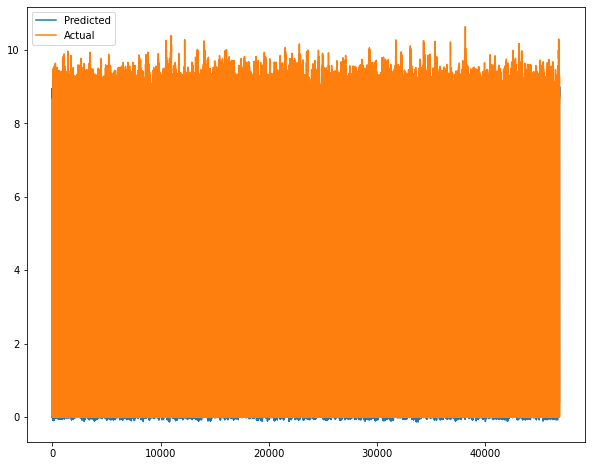

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(y_pred_gen)
plt.plot(np.array(y_test_gen))
plt.legend(["Predicted","Actual"])
plt.show()

After checking generative function efficiency let's generate data for the next 6 weeks to predict sales for the problem statement.

In [ ]:
data_advance = generate_date_for_six_week(last_date + timedelta(1))
data_advance

,Store,Date_time,DayOfWeek,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Month,Day,CompetitionDistance,Store_Type,Assortment_Level,Promo_cont,CompetitionTime
0,1,2015-08-01,6,1,0,1,0,0,0,8,1,1270.0,3,1,0,2020
1,1,2015-08-02,7,0,0,1,0,0,0,8,2,1270.0,3,1,0,2020
2,1,2015-08-03,1,1,0,0,0,0,0,8,3,1270.0,3,1,0,2020
3,1,2015-08-04,2,1,0,1,0,0,0,8,4,1270.0,3,1,0,2020
4,1,2015-08-05,3,1,0,1,0,0,0,8,5,1270.0,3,1,0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46825,1115,2015-09-07,1,1,0,0,0,0,0,9,7,5350.0,4,3,1,0
46826,1115,2015-09-08,2,1,0,0,0,0,0,9,8,5350.0,4,3,1,0
46827,1115,2015-09-09,3,1,0,0,0,0,0,9,9,5350.0,4,3,1,0
46828,1115,2015-09-10,4,1,0,0,0,0,0,9,10,5350.0,4,3,1,0


In [ ]:
# get test dataset for generated data
X_test_gen_adv = data_advance.drop(columns=['Date_time']).values
# scale the dataset to feed it in model
X_test_gen_adv = scaler.transform(X_test_gen_adv)

In [ ]:
# use stack model to predict the result
y_pred_gen_adv = stack_predict(X_test_gen_adv)

We got out predictions but they are in log transform state, we need to convert them into proper sales value.

In [ ]:
# apply exponent function to convert log values to original Sales value
final_pred = np.exp(y_pred_gen_adv)
# total of Sales for next 6 week
total = int(sum(final_pred))
print('Total of Predicted Sales in next 6 week will be: ' + str(total))

Total of Predicted Sales in next 6 week will be: 250800522


In [ ]:
data_advance['Sales'] = final_pred.astype(np.int)
data_advance.head()

,Store,Date_time,DayOfWeek,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Month,Day,CompetitionDistance,Store_Type,Assortment_Level,Promo_cont,CompetitionTime,Sales
0,1,2015-08-01,6,1,0,1,0,0,0,8,1,1270.0,3,1,0,2020,5324
1,1,2015-08-02,7,0,0,1,0,0,0,8,2,1270.0,3,1,0,2020,1
2,1,2015-08-03,1,1,0,0,0,0,0,8,3,1270.0,3,1,0,2020,5793
3,1,2015-08-04,2,1,0,1,0,0,0,8,4,1270.0,3,1,0,2020,5769
4,1,2015-08-05,3,1,0,1,0,0,0,8,5,1270.0,3,1,0,2020,5648
